# Web Scraping Craigslist Apartments in East Bay

In [48]:
#import get to call a get request on the site
from requests import get

#get the first page of the east bay housing prices
response = get('https://sfbay.craigslist.org/search/eby/apa?hasPic=1&availabilityMode=0') #get rid of those lame-o's that post a housing option without a pic using their filter

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print(len(posts)) #to double check I got 120 (elements/page)

<class 'bs4.element.ResultSet'>
120


In [49]:
#grab the first post
post_one = posts[1]

In [50]:
#grab the price of the first post
post_one_price = post_one.a.text
post_one_price.strip()

'$2,535'

In [51]:
#grab the time of the post in datetime format to save on cleaning efforts
post_one_time = post_one.find('time', class_= 'result-date')
post_one_datetime = post_one_time['datetime']

In [52]:
#title is a and that class, link is grabbing the href attribute of that variable
post_one_title = post_one.find('a', class_='result-title hdrlnk')
post_one_link = post_one_title['href']

#easy to grab the post title by taking the text element of the title variable
post_one_title_text = post_one_title.text


In [53]:
post_one

<li class="result-row" data-pid="7441293486">
<a class="result-image gallery" data-ids="3:00X0X_l2fhP9SFL8tz_0jm0cU,3:00i0i_k3wDPHhkYZEz_0gw0co,3:01010_b29KConhCInz_0jm0cU,3:00606_27y50orkfQ1z_0jm0cU,3:01010_gARNUpD2Demz_0jm0cU,3:01616_6onIRtTxFxpz_0jm0cU,3:01717_j5p0P4MegTTz_0jm0cU,3:00a0a_67fAPAYeWT8z_0jm0cU,3:00d0d_6gbOxd4DCaAz_04c04c" href="https://sfbay.craigslist.org/eby/apa/d/hayward-mirrored-wardrobe-nine-laundry/7441293486.html">
<span class="result-price">$2,535</span>
</a>
<div class="result-info">
<span class="icon icon-star" role="button">
<span class="screen-reader-text">favorite this post</span>
</span>
<time class="result-date" datetime="2022-02-21 20:13" title="Mon 21 Feb 08:13:52 PM">Feb 21</time>
<h3 class="result-heading">
<a class="result-title hdrlnk" data-id="7441293486" href="https://sfbay.craigslist.org/eby/apa/d/hayward-mirrored-wardrobe-nine-laundry/7441293486.html" id="postid_7441293486">Mirrored Wardrobe, Nine Laundry Rooms, Night Patrol</a>
</h3>
<span cla

In [60]:
#grabs the whole segment of housing details. We will need missing value handling in the loop as this kind of detail is not common in posts
#the text can be split, and we can use indexing to grab the elements we want. number of bedrooms is the first element.
#sqft is the third element
post_one_num_bedrooms = post_one.find('span', class_ = 'housing').text.split()[0]

post_one_sqft = post_one.find('span', class_ = 'housing').text.split()[2][:-3] #cleans the ft2 at the end

In [61]:
#the neighborhood is grabbed by finding the span class 'result-hood' and pulling the text element from that
post_one_hood = posts[0].find('span', class_='result-hood').text

In [67]:
#build out the loop
from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

#each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for page in pages:
    
    #get request
    response = get("https://sfbay.craigslist.org/search/eby/apt?" 
                   + "s=" #the parameter for defining the page number 
                   + str(page) #the page number in the pages array from earlier
                   + "&hasPic=1"
                   + "&availabilityMode=0")

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            post_price = post.a.text.strip().replace("$", "")
            post_price = int(post_price.replace(",", ""))
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!
Page 12 scraped successfully!
Page 13 scraped successfully!
Page 14 scraped successfully!
Page 15 scraped successfully!
Page 16 scraped successfully!
Page 17 scraped successfully!
Page 18 scraped successfully!
Page 19 scraped successfully!
Page 20 scraped successfully!
Page 21 scraped successfully!
Page 22 scraped successfully!
Page 23 scraped successfully!
Page 24 scraped successfully!
Page 25 scraped successfully!
Page 26 scraped successfully!


Scrape complete!


# Data Cleaning

In [69]:
import pandas as pd

eb_apts = pd.DataFrame({'posted': post_timing,
                       'neighborhood': post_hoods,
                       'post title': post_title_texts,
                       'number bedrooms': bedroom_counts,
                        'sqft': sqfts,
                        'URL': post_links,
                       'price': post_prices})
print(eb_apts.info())
eb_apts.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3120 entries, 0 to 3119
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   posted           3120 non-null   object 
 1   neighborhood     3120 non-null   object 
 2   post title       3120 non-null   object 
 3   number bedrooms  2652 non-null   object 
 4   sqft             1794 non-null   float64
 5   URL              3120 non-null   object 
 6   price            3120 non-null   int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 170.8+ KB
None


,posted,neighborhood,post title,number bedrooms,sqft,URL,price
0,2022-02-21 20:14,( east bay area ),"3Bdrm, 2Bath + Bonus Room, 4Plex",3,NaN,https://sfbay.craigslist.org/eby/apa/d/3bdrm-2...,2695
1,2022-02-21 20:13,(hayward / castro valley),"Mirrored Wardrobe, Nine Laundry Rooms, Night P...",2,840.0,https://sfbay.craigslist.org/eby/apa/d/hayward...,2535
2,2022-02-21 20:13,(hayward / castro valley),All utilities included 1 bedroom 1 bath in-law...,1,400.0,https://sfbay.craigslist.org/eby/apa/d/hayward...,1450
3,2022-02-21 20:12,(berkeley),"2321 Dwight Way, South Campus. Newly renovated...",NaN,NaN,https://sfbay.craigslist.org/eby/apa/d/berkele...,1950
4,2022-02-21 20:12,(berkeley),2732 Haste St. Balcony. 3 blocks to UCB. Laund...,2,NaN,https://sfbay.craigslist.org/eby/apa/d/berkele...,3100
5,2022-02-21 20:12,(emeryville),One Bedroom Apartment for Rent,1,1000.0,https://sfbay.craigslist.org/eby/apa/d/emeryvi...,2000
6,2022-02-21 20:11,(berkeley north / hills),1910 Berryman@Shattuck Ave. Bart close by. Bal...,2,NaN,https://sfbay.craigslist.org/eby/apa/d/berkele...,3000
7,2022-02-21 20:11,(berkeley north / hills),1910 Berryman. Off Shattuck Ave. Bart close by...,2,700.0,https://sfbay.craigslist.org/eby/apa/d/berkele...,2800
8,2022-02-21 20:10,(berkeley north / hills),1406 Henry street. Gourmet Ghetto one bedroom....,1,NaN,https://sfbay.craigslist.org/eby/apa/d/berkele...,2375
9,2022-02-21 20:08,(berkeley north / hills),Furnished North Berkeley Home. Panoramic Bay V...,3,2200.0,https://sfbay.craigslist.org/eby/apa/d/berkele...,5875


In [70]:
#first things first, drop duplicate URLs because people are spammy on Craigslist. 
#Let's see how many uniqe posts we really have.
eb_apts = eb_apts.drop_duplicates(subset='URL')
len(eb_apts.drop_duplicates(subset='URL'))

#make the number bedrooms to a float (since np.nan is a float too)
eb_apts['number bedrooms'] = eb_apts['number bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to be able to work with it
from datetime import datetime

eb_apts['posted'] = pd.to_datetime(eb_apts['posted'])

#Looking at what neighborhoods there are with eb_apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

#remove the parenthesis from the left and right of the neighborhoods
eb_apts['neighborhood'] = eb_apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))

#titlecase them
eb_apts['neighborhood'] = eb_apts['neighborhood'].str.title()

#just take the first name of the neighborhood list, splitting on the '/' delimiter
eb_apts['neighborhood'] = eb_apts['neighborhood'].apply(lambda x: x.split('/')[0])

#fix one-offs that
eb_apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
eb_apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)

#remove whitespaces
eb_apts['neighborhood'] = eb_apts['neighborhood'].apply(lambda x: x.strip())

# Exploratory Data Analysis

In [71]:
eb_apts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   posted           120 non-null    datetime64[ns]
 1   neighborhood     120 non-null    object        
 2   post title       120 non-null    object        
 3   number bedrooms  102 non-null    float64       
 4   sqft             69 non-null     float64       
 5   URL              120 non-null    object        
 6   price            120 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 7.5+ KB


In [72]:
import pandas as pd, numpy as np
#I think Craigslist blocked me. Reload dataframe via file for now
eb_apts = pd.read_csv("eb_apts_1642_Jan_2_19_clean.csv")

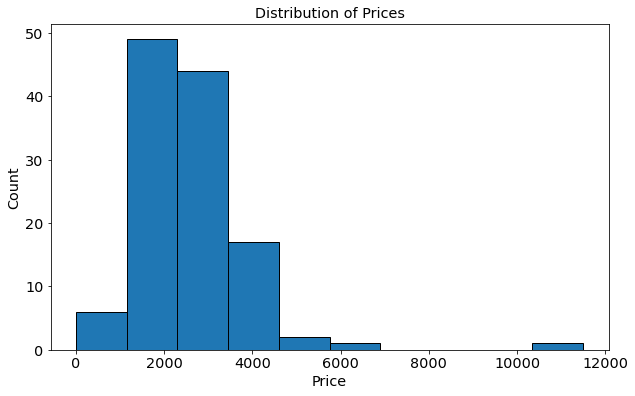

In [74]:
#start to look at the distributions
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.hist(eb_apts['price'], edgecolor='black');
plt.xlabel("Price")
plt.ylabel('Count')
plt.title("Distribution of Prices");

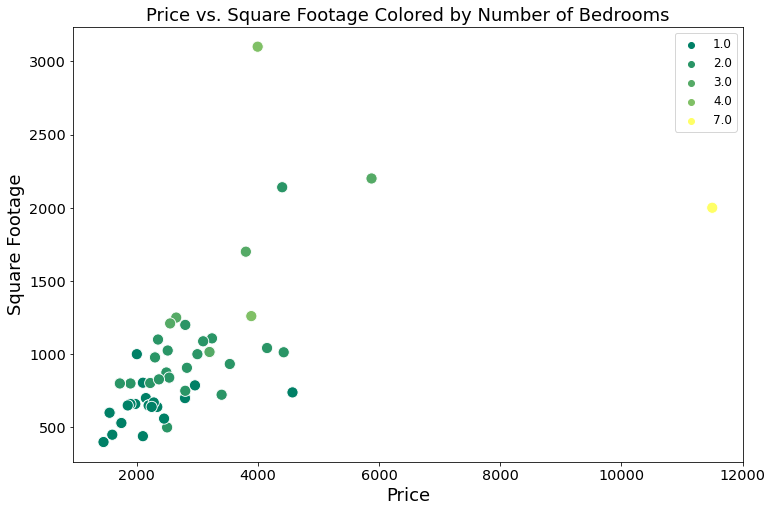

In [75]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='price', y='sqft', hue='number bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=eb_apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);

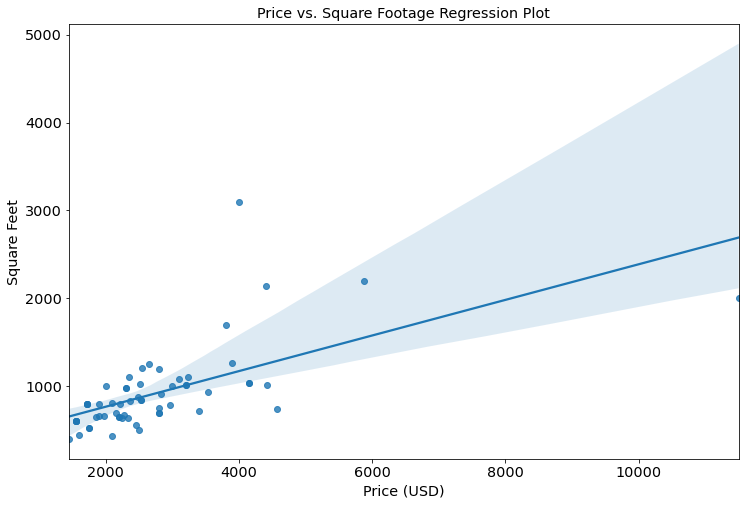

In [76]:
plt.figure(figsize=(12, 8))
sns.regplot(x='price', y='sqft', data=eb_apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price (USD)");
plt.ylabel("Square Feet");

In [77]:
eb_apts.corr()

,number bedrooms,sqft,price
number bedrooms,1.000000,0.717213,0.680481
sqft,0.717213,1.000000,0.654694
price,0.680481,0.654694,1.000000


In [78]:
#group by neighborhood
eb_apts.groupby('neighborhood').mean()

,number bedrooms,sqft,price
neighborhood,,,
Alameda,1.666667,771.500000,2829.285714
Albany,1.666667,1583.333333,2220.555556
Berkeley,1.833333,717.200000,2822.647059
Berkeley North,2.833333,1204.600000,4407.142857
Concord,1.400000,825.750000,1760.166667
Dublin,2.500000,967.000000,3073.750000
East Bay Area,3.473684,NaN,3126.578947
Emeryville,1.000000,1000.000000,2000.000000
Fairfield,NaN,NaN,0.000000


In [79]:
eb_apts['neighborhood'].replace('North Oakland', 'Oakland North', inplace=True)


In [80]:
#sort price to find cheapest
eb_apts.groupby('neighborhood').mean()['price'].sort_values()

neighborhood
Fairfield                  0.000000
Pittsburg               1150.000000
San Leandro             1300.000000
Vallejo                 1463.000000
Oakland West            1620.000000
Concord                 1760.166667
Oakland East            1895.000000
Walnut Creek            1975.000000
Emeryville              2000.000000
Richmond                2183.333333
Hercules                2195.000000
Albany                  2220.555556
Fremont                 2297.500000
Oakland Lake Merritt    2335.000000
Hayward                 2456.142857
Oakland North           2583.333333
Berkeley                2822.647059
Oakland Piedmont        2827.000000
Alameda                 2829.285714
Oakland Downtown        3015.250000
Dublin                  3073.750000
East Bay Area           3126.578947
Berkeley North          4407.142857
Name: price, dtype: float64

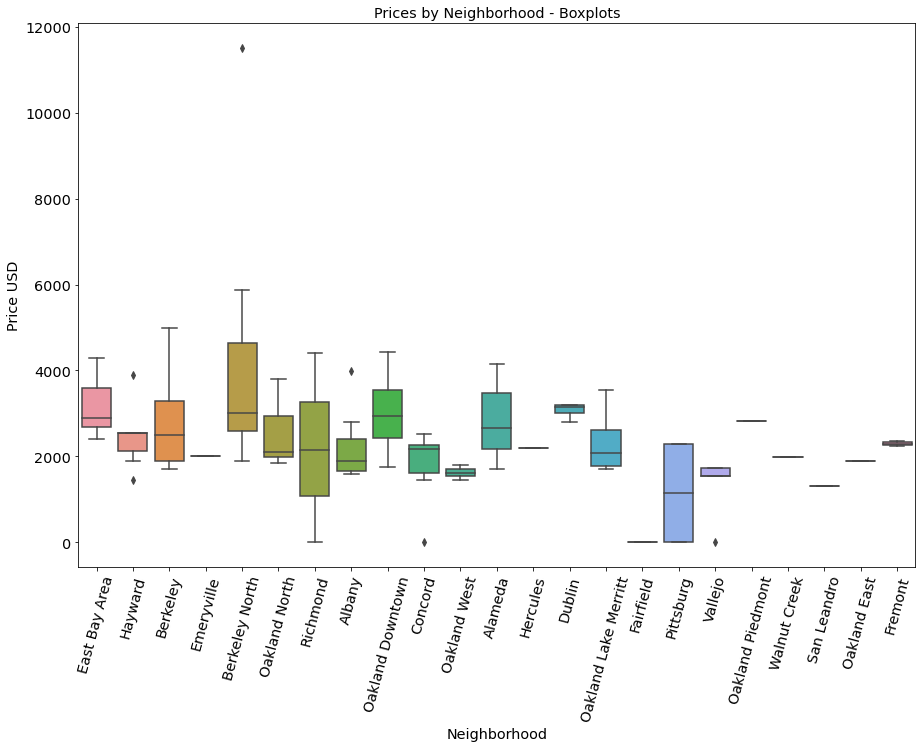

In [83]:
plt.figure(figsize=(15,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.boxplot(x='neighborhood', y='price', data=eb_apts)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots");